2.2.2 在鸢尾花数据集上训练感知器模型

In [3]:
import pandas as pd
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data", header=None)
df.tail()

,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


In [4]:
df.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
df.describe()

,0,1,2,3
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [6]:
import matplotlib.pyplot as plt
import numpy as np

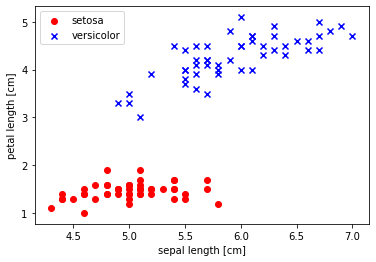

In [7]:
# select setosa and versicolor
y = df.iloc[0:100, 4].values
y = np.where(y =='Iris-setosa', -1, 1)

# extract sepal length and petal length
X = df.iloc[0:100, [0, 2]].values

plt.scatter(X[:50, 0], X[:50, 1], color='red', marker='o', label='setosa')
plt.scatter(X[50:100, 0], X[50:100, 1], color='blue', marker='x', label='versicolor')
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')
plt.show()

In [8]:
df.columns

Int64Index([0, 1, 2, 3, 4], dtype='int64')

In [9]:
df.count()

0    150
1    150
2    150
3    150
4    150
dtype: int64

In [10]:
df[4].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

感知器Perceptron

In [11]:
class Perceptron(object):
    def __init__(self, eta=0.1, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1+X.shape[1])
        self.errors_ = []
        for _ in range(self.n_iter):
            errors = 0
            zip_tmp = zip(X, y)
            for xi, target in zip_tmp:
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0:] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def predict(self, X):
        return np.where(self.net_input(X)>=0.0, 1, -1)

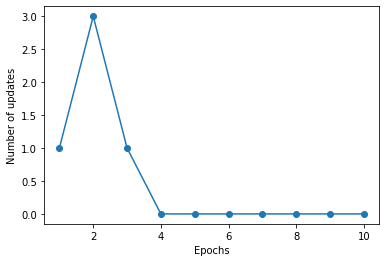

In [12]:
ppn = Perceptron(eta=0.1, n_iter=10)
ppn.fit(X, y)
plt.plot(range(1, len(ppn.errors_)+1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')
plt.show()

In [13]:
# pay attention to the 4th update. It converges at 4th node.

from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, resolution=0.02):
#     setup marker generator and color map
    markers = ('s','x','o','^','v')
    colors = ('red','blue','lightgreen','gray','cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
#     plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 0].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(),xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
#     plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x = X[y==cl, 0], 
                    y = X[y==cl, 1],
                    alpha = 0.8,
                    c = colors[idx],
                    marker = markers[idx],
                    label = cl,
                    edgecolor = 'black')

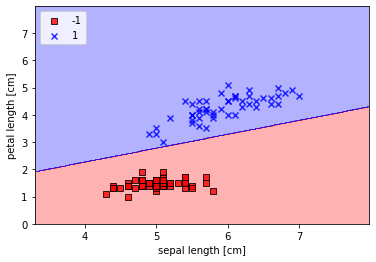

In [14]:
plot_decision_regions(X, y, classifier=ppn)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')
plt.show()

### 2.3 梯度下降为最小代价函数 Adaline

2.3.1 用Python实现Adaline

In [15]:
class AdalineGD(object):
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1+X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum()/2.0
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        return X
    
    def predict(self, X):
        return np.where(self.activation(self.net_input(X))>=0.0, 1, -1)

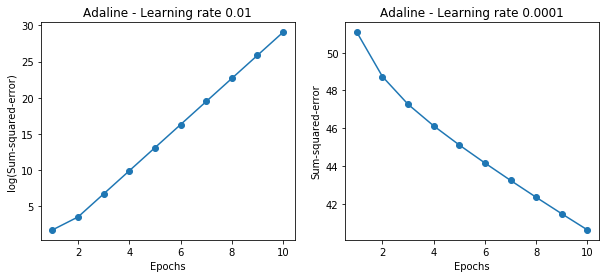

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
adal = AdalineGD(n_iter=10, eta=0.01).fit(X, y)

ax[0].plot(range(1, len(adal.cost_)+1), 
           np.log10(adal.cost_), 
           marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - Learning rate 0.01')

ada2 = AdalineGD(n_iter=10, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.cost_)+1),
          ada2.cost_, 
          marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Sum-squared-error')
ax[1].set_title('Adaline - Learning rate 0.0001')
plt.show()

2.3.3 通过调整特征大小改善梯度下降

In [19]:
# 用内置的numpy方法mean和std可以很容易实现标准化
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean())/X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean())/X[:, 1].std()

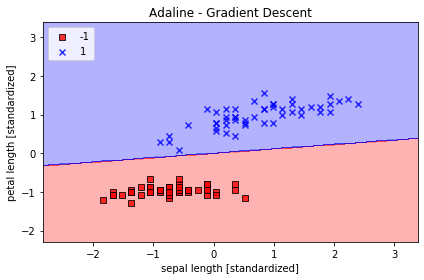

In [21]:
ada = AdalineGD(n_iter=15, eta=0.01)
ada.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

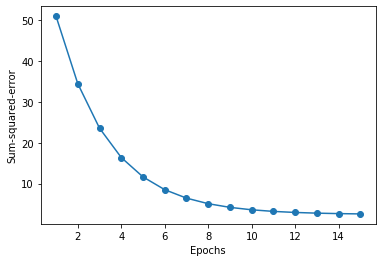

In [22]:
plt.plot(range(1, len(ada.cost_)+1),
        ada.cost_,
        marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.show()

2.3.4 大规模机器学习与随即梯度下降

In [26]:
class AdalineSGD(object): # stochastic gradient descent
    def __init__(self, eta=0.01, n_iter=10,
                shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
    
    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost)/len(y)
            self.cost_.append(avg_cost)
        return self
    
    def partial_fit(self, X, y):
        if not self.w_initialized:
            self.initialize_weight(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weight(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1+m)
        self.w_initialized = True
    
    def _update_weights(self, xi, target):
        output = self.activation(self.net_input(xi))
        error = (target-output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta *  error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:] + self.w_[0])
    
    def activation(self, X):
        return X
    
    def predict(self, X):
        return np.where(self.activation(self.net_input(X))>=0, 1, -1)    

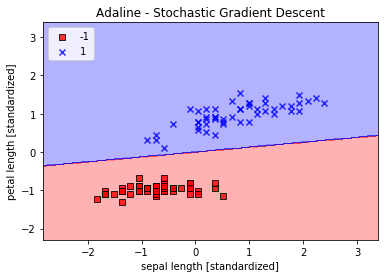

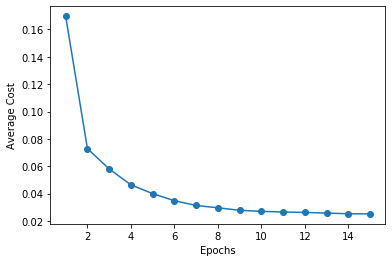

In [27]:
ada = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada)
plt.title("Adaline - Stochastic Gradient Descent")
plt.xlabel("sepal length [standardized]")
plt.ylabel("petal length [standardized]")
plt.legend(loc='upper left')
plt.show()

plt.plot(range(1, len(ada.cost_)+1), ada.cost_, marker='o')
plt.xlabel("Epochs")
plt.ylabel("Average Cost")
plt.show()